### References:
-  UNESCO-IHE [Transient Groundwater Flow](https://transientgroundwaterflow.readthedocs.io/en/latest/TransientFlowToAWell.html)
- Walton (1979) [Groundwater Resource Evaluation](http://hydrogeologistswithoutborders.org/wordpress/1979-english/chapter-8/#8.3-The-Response)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import scipy.special as sp


In [2]:
def TheisSolution(r,t, Q, storativity, transmissivity):
    u = r*r * storativity / (4.0*t*transmissivity)  
    return -(Q/(4.0*np.pi*transmissivity))*sp.expi( -u )
    

In [3]:
t = 30.0/60.0/24 # 30 minutes
r = np.logspace(-2,3,1000)

T = 392  # Transmissivity [m^2/day]
S = 1.6e-4 # Storativity [unitless]
Q = 788  # Pumping rate [m^3/day]


drawdown = TheisSolution(r,t, Q, S,T)

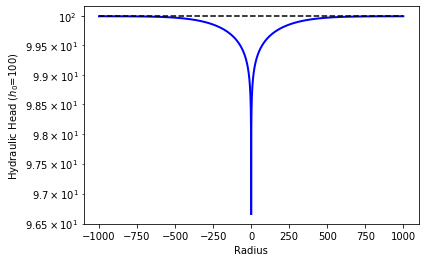

In [4]:
# Background head used for plotting
h0 = 100

plt.semilogy(r,h0-drawdown,  'b', linewidth=2, basey=10)
plt.semilogy(-r,h0-drawdown, 'b', linewidth=2, basey=10)
plt.semilogy([-r[-1], r[-1]],[h0,h0], '--k')
plt.xlabel('Radius')
plt.ylabel('Hydraulic Head ($h_0$=100)')
plt.show()


### Define the observational data 
See the "Pumping Test" section of [Transient Groundwater Flow](https://transientgroundwaterflow.readthedocs.io/en/latest/TheisWellFunction.html) for more details.  The data comes from a pump test in the Netherlands that is described in the book "Analysis and Evaluation of Pumping Test Data" by Kruseman and De Ridder.

In [5]:
# Set the pumping rate used during the test
pump_rate = 788  # [m^3 / day]
obs_radii = 30.0

obs_std = 0.01 # Standard deviation of 1cm


# Observations from well at r=30m.  First column is time in minutes, second is drawdown in meters
H30 = np.array([[0.1, 0.04],
        [0.25, 0.08],
        [0.50, 0.13],
        [0.70, 0.18],
        [1.00, 0.23],
        [1.40, 0.28],
        [1.90, 0.33],
        [2.33, 0.36],
        [2.80, 0.39],
        [3.36, 0.42],
        [4.00, 0.45],
        [5.35, 0.50],
        [6.80, 0.54],
        [8.30, 0.57],
        [8.70, 0.58],
        [10.0, 0.60],
        [13.1, 0.64]])

obs_times = H30[:,0]/60./24.  # Dividing by 60*24 converts to units of days 
obs_vals = H30[:,1]



### Define the prior and likelihood

In [6]:
def LogLikelihood(params, obs_vals):
    """
    Evaluate the log-likelihood function by comparing the 
    Theis model output to the observations with 
    
    """

    obs_var = obs_std*obs_std
    
    S = params[0] # Pull out the storativity
    T = params[1] # Pull out the transmissivity
    
    # Predict the drawdown at the observation well
    drawdown = TheisSolution(obs_radii, obs_times, pump_rate, S,T)
    
    # evaluate the log likelihood up to a normalizing constant
    return -(0.5/obs_var)*np.sum((obs_vals - drawdown)**2)


def LogPrior(params):
    """
    Evaluates the log of the prior density.
    """
    
    logT = np.log10(params[1]) # Pull out the transmissivity
    logS = np.log10(params[0]) # Pull out the storativity
    
    log_trans_mean = np.log10(400) # Mean of the normal distribution on log(transimissivity)
    log_trans_var = 2.0**2 # Variance of the normal distribution on log(transmissivity)
    
    log_store_mean = np.log10(2e-4)# Mean of the normal distribution on log(storativity)
    log_store_var = 2.0**2 # Variance of the normal distribution on log(storativity)
    
    return -(0.5/log_trans_var)*(logT-log_trans_mean)**2 - (0.5/log_store_var)*(logS-log_store_mean)**2
    
    
def LogPosterior(params, obs_vals):
    """ Returns the log posterior (up to a normalizing constant) """
    
    return LogPrior(params) + LogLikelihood(params,obs_vals)

### Sample the posterior with MCMC

In [54]:
num_steps = 5000
S0 = 2e-4  # Initial value for the storavity
T0 = 400 # Initial value for the transmissivity

# Scale on the proposal standard deviation
prop_scale = 3e-3
prop_stds = np.array([prop_scale*S0, prop_scale*T0])


# Intialize empty arrays for the thickness samples the log posterior pdfs at each sample
num_params = 2
samps = np.zeros((num_steps, num_params))
log_pdfs = np.zeros((num_steps))

# set the initial transmissivity and storativity
samps[0,:] = np.array([S0,T0]) 
log_pdfs[0] = LogPosterior(samps[0,:], obs_vals)

num_accepts = 0 
for i in range(num_steps-1):
    
    # Generate a proposed move
    prop = samps[i,:] + prop_stds*np.random.randn(num_params)
    
    # Evaluate the log posterior at the proposed point
    prop_log_pdf = LogPosterior(prop, obs_vals)

    # Compute the acceptance ratio
    gamma = np.exp(prop_log_pdf - log_pdfs[i])
    
    # Metroplis Accept/Reject Step
    u = np.random.rand()
    if(u<gamma):
        num_accepts += 1
        samps[i+1,:] = prop
        log_pdfs[i+1] = prop_log_pdf
    else:
        samps[i+1,:] = samps[i,:]
        log_pdfs[i+1]  = log_pdfs[i]
    
    if(((i%500)==0)&(i>0)):
        print('Step %d, Acceptance Rate = %0.2f'%(i,num_accepts/(i+1)))
    

Step 500, Acceptance Rate = 0.83
Step 1000, Acceptance Rate = 0.86
Step 1500, Acceptance Rate = 0.86
Step 2000, Acceptance Rate = 0.86
Step 2500, Acceptance Rate = 0.86
Step 3000, Acceptance Rate = 0.86
Step 3500, Acceptance Rate = 0.86
Step 4000, Acceptance Rate = 0.86
Step 4500, Acceptance Rate = 0.86


## Make Trace Plots

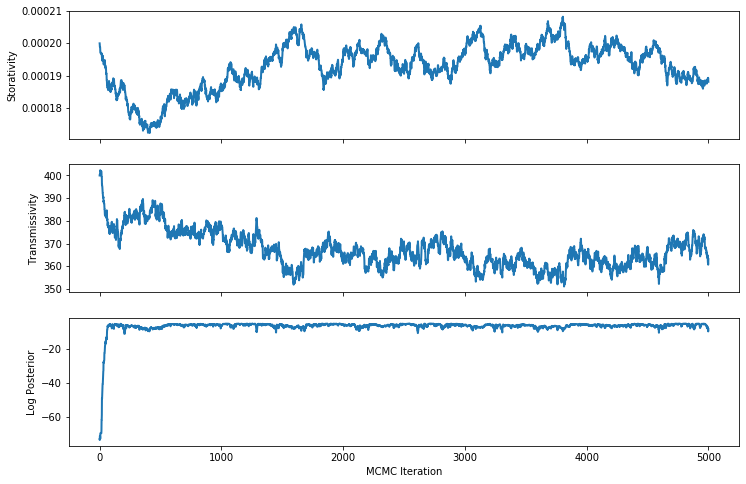

In [55]:

fig, axs = plt.subplots(nrows=3,sharex=True, figsize=(12,8))
axs[0].plot(samps[:,0], linewidth=2)
axs[0].set_ylabel('Storativity')

axs[1].plot(samps[:,1], linewidth=2)
axs[1].set_ylabel('Transmissivity')

axs[2].plot(log_pdfs, linewidth=2)
axs[2].set_ylabel('Log Posterior')
axs[2].set_xlabel('MCMC Iteration')

plt.show()


## Look at the autocorrelation of the chain

In [56]:
burn_in = 100

In [57]:
temp = samps[burn_in:,0]-np.mean(samps[burn_in:,0])
corr1 = np.correlate(temp, temp, mode='same')
corr1 /= np.max(corr1) # normalize so the maximum autocorrelation is 1
corr1 = corr1[int((num_steps-burn_in)/2):]

temp = samps[burn_in:,1]-np.mean(samps[burn_in:,1])
corr2 = np.correlate(temp,temp, mode='same')
corr2 /= np.max(corr2) # normalize so the maximum autocorrelation is 1
corr2 = corr2[int((num_steps-burn_in)/2):]

Estimated IACT = 761.03


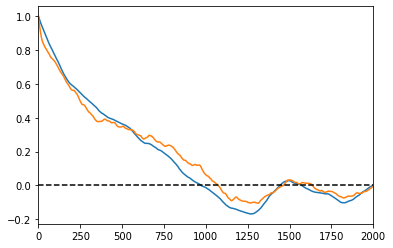

In [64]:
plt.plot(corr1, label='First Component')
plt.plot(corr2, label='Second Component')
plt.plot([0,num_steps/2],[0,0],'--k')

plt.xlim([0,2000])

iact = 1 + 2*np.sum(corr1[1:1000])
print('Estimated IACT = %0.2f'%iact)

# Breakout Exercise:
Try to find the proposal scale that makes the autocorrelation function decay as quickly as possible. How do the trace plots change?

## Plot the posterior samples

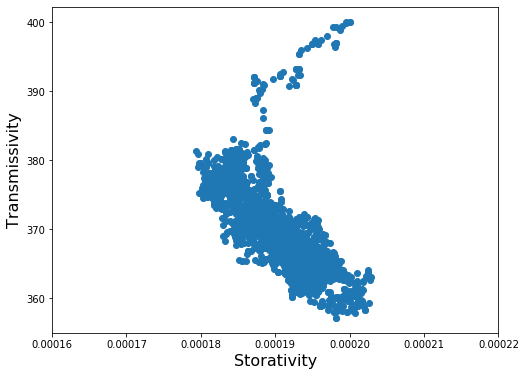

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(samps[:,0], samps[:,1])
plt.xlim([1.6e-4, 2.2e-4])

plt.xlabel('Storativity', fontsize=16)
plt.ylabel('Transmissivity', fontsize=16)
plt.show()

### Make a posterior predictive plot

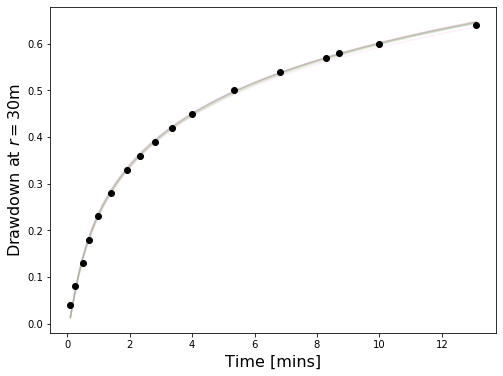

In [13]:
plt.figure(figsize=(8,6))
burn_in = 100

for samp_ind in np.arange(burn_in,num_steps,200):
    pred_times = np.linspace(obs_times[0], obs_times[-1], 100)
    drawdown = TheisSolution(obs_radii, pred_times, pump_rate, samps[samp_ind,0], samps[samp_ind,1])
    
    plt.plot(24*60*pred_times, drawdown, alpha=0.1)
    
plt.plot(24*60*obs_times, obs_vals, 'ok')
plt.xlabel('Time [mins]',fontsize=16)
plt.ylabel('Drawdown at $r=30$m',fontsize=16)
plt.show()